# Specific versions and imports

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
import os
import cv2
import random
import yaml
import json
import matplotlib.pyplot as plt
import ultralytics
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
import pandas as pd
import torch
from IPython.display import display

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
random_seed = 42
random.seed(random_seed)

# Phiên bản của các thư viện đã import
versions = {
    'os': 'built-in',
    'cv2': cv2.__version__,
    'random': 'built-in',
    'yaml': yaml.__version__,
    'json': json.__version__,
    'matplotlib': plt.matplotlib.__version__,
    'PIL': Image.__version__ if hasattr(Image, '__version__') else 'no __version__',
    'ultralytics': ultralytics.__version__,
    'pandas': pd.__version__,
    'torch': torch.__version__,
}

df_versions = pd.DataFrame(list(versions.items()), columns=['Library', 'Version'])
display(df_versions)

Library      Version
0           os     built-in
1          cv2       4.11.0
2       random     built-in
3         yaml        6.0.2
4         json        2.0.9
5   matplotlib        3.7.2
6          PIL       11.1.0
7  ultralytics      8.3.142
8       pandas        2.2.3
9        torch  2.6.0+cu124

In [4]:
torch.cuda.get_device_name(0)

'Tesla T4'

# Data Processing

In [5]:
# Chuyển đổi json theo định dạng YOLO cho tập Train
json_path = '/kaggle/input/seadronessee/compressed/annotations/instances_train.json'
images_dir = '/kaggle/working/train_labels'

# Thư mục lưu label YOLO 
labels_dir = os.path.join(images_dir, '')
os.makedirs(labels_dir, exist_ok=True)

with open(json_path, 'r') as f:
    coco = json.load(f)

images = {img["id"]: (img["file_name"], img["width"], img["height"]) for img in coco["images"]}
annotations = coco["annotations"]

for ann in annotations:
    image_id = ann["image_id"]
    cat_id = ann["category_id"]
    # Nếu không cần bỏ class nào thì bỏ phần if tiếp theo
    # if cat_id == 0:
    #     continue

    x, y, w, h = ann["bbox"]
    file_name, img_w, img_h = images[image_id]
    
    # Chuẩn hóa tọa độ
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    norm_w = w / img_w
    norm_h = h / img_h

    line = f"{cat_id - 1} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n"
    label_path = os.path.join(labels_dir, file_name.replace('.jpg', '.txt'))
    with open(label_path, 'a') as f:
        f.write(line)

In [6]:
# Chuyển đổi json theo định dạng YOLO cho tập Valid (đã được thầy lọc bớt tệp ảnh)
json_path_val = '/kaggle/input/seadronessee/compressed/annotations/instances_val.json'
images_dir_val = '/kaggle/working/val_labels'  # thư mục ảnh val hoặc nơi bạn lưu labels val

labels_dir_val = os.path.join(images_dir_val, '')
os.makedirs(labels_dir_val, exist_ok=True)

with open(json_path_val, 'r') as f:
    coco_val = json.load(f)

images_val = {img["id"]: (img["file_name"], img["width"], img["height"]) for img in coco_val["images"]}
annotations_val = coco_val["annotations"]

for ann in annotations_val:
    image_id = ann["image_id"]
    cat_id = ann["category_id"]

    x, y, w, h = ann["bbox"]
    file_name, img_w, img_h = images_val[image_id]

    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    norm_w = w / img_w
    norm_h = h / img_h

    line = f"{cat_id - 1} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n"
    label_path = os.path.join(labels_dir_val, file_name.replace('.jpg', '.txt'))
    with open(label_path, 'a') as f:
        f.write(line)


In [7]:
# Lưu hai thư mục chứa dữ liệu đã xử lý labels
from IPython.display import FileLink

!zip -r /kaggle/working/train_labels.zip /kaggle/working/train_labels
!zip -r /kaggle/working/val_labels.zip /kaggle/working/val_labels

FileLink('/kaggle/working/train_labels.zip')
FileLink('/kaggle/working/val_labels.zip')

  adding: kaggle/working/train_labels/ (stored 0%)
  adding: kaggle/working/train_labels/10391.txt (deflated 57%)
  adding: kaggle/working/train_labels/6905.txt (deflated 56%)
  adding: kaggle/working/train_labels/6018.txt (deflated 52%)
  adding: kaggle/working/train_labels/1964.txt (deflated 55%)
  adding: kaggle/working/train_labels/11146.txt (deflated 5%)
  adding: kaggle/working/train_labels/12898.txt (deflated 55%)
  adding: kaggle/working/train_labels/10190.txt (deflated 54%)
  adding: kaggle/working/train_labels/10398.txt (deflated 58%)
  adding: kaggle/working/train_labels/8461.txt (deflated 56%)
  adding: kaggle/working/train_labels/2855.txt (deflated 57%)
  adding: kaggle/working/train_labels/16297.txt (deflated 53%)
  adding: kaggle/working/train_labels/5449.txt (deflated 51%)
  adding: kaggle/working/train_labels/10685.txt (deflated 52%)
  adding: kaggle/working/train_labels/10290.txt (deflated 57%)
  adding: kaggle/working/train_labels/11484.txt (deflated 40%)
  adding: k

/kaggle/working/val_labels.zip

Sau khi lưu được hai file /.zip labels của tập Train và Valid, giải nén tệp và thêm dữ liệu labels vào bộ dữ liệu gốc nằm cùng thư mục với thư mục 'images'. Upload bộ dữ liệu mới (có kèm ảnh và nhãn) để phục vụ việc huấn luyện.

In [8]:
# Tạo file data.yaml
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

yaml_file_name = 'data.yaml'
yaml_data = {
    'train': f'/kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train',
    'val': f'/kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/val',
    'nc': 5,   # Bỏ class 0 = ignored
    'names': ['swimmer', 'boat', 'jetski', 'life_saving_appliances', 'buoy']
}

yaml_path = os.path.join(output_dir, yaml_file_name)

with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

print(f"File data.yaml được tạo tại: {yaml_path}")

File data.yaml được tạo tại: /kaggle/working/data.yaml


# Show some input images/labels 

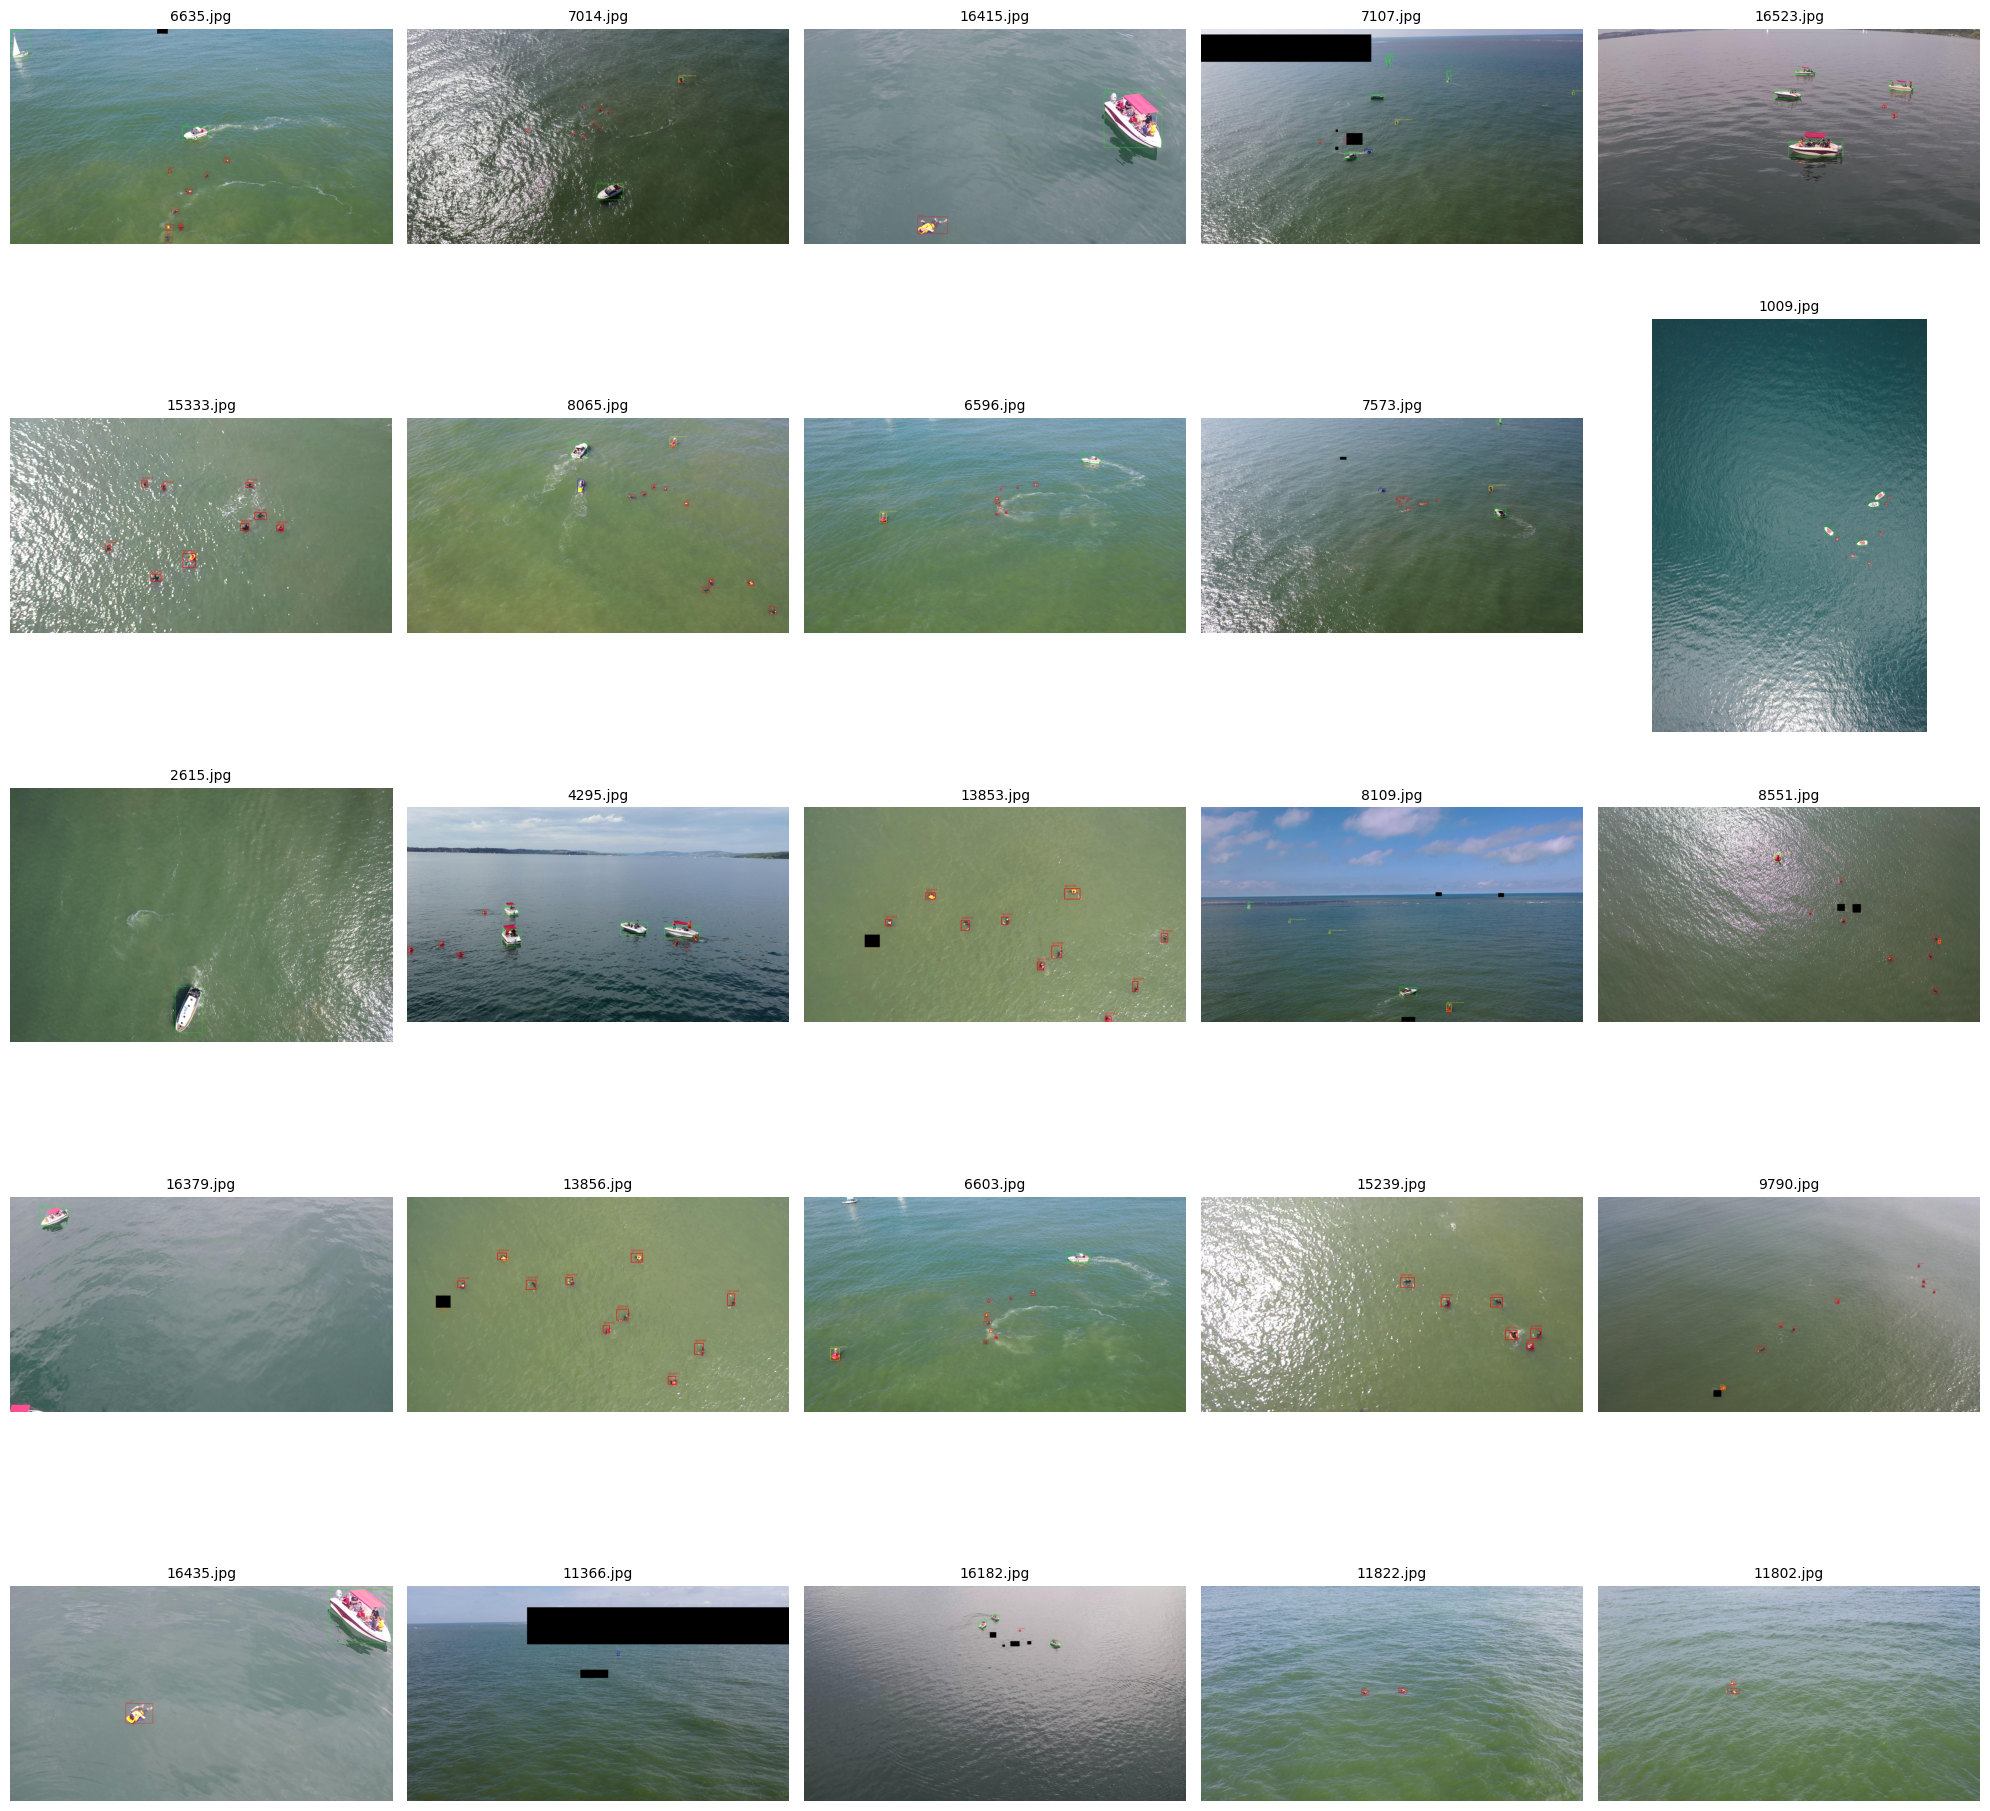

In [9]:
image_dir = "/kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train"  
label_dir = "/kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/labels/train"  # thư mục label tương ứng

# Class names theo SeaDronesSee
class_names = ['ignored', 'swimmer', 'boat', 'jetski', 'life_saving_appliances', 'buoy']

# Màu sắc cho từng class 
colors = {
    0: (128, 128, 128),   # ignored - màu xám
    1: (255, 0, 0),       # swimmer - đỏ
    2: (0, 255, 0),       # boat - xanh lá
    3: (0, 0, 255),       # jetski - xanh dương
    4: (255, 165, 0),     # life_saving_appliances - cam
    5: (255, 255, 0)      # buoy - vàng
}

# Hàm vẽ bounding box với class SeaDronesSee
def draw_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                raw_class_id, x_center, y_center, w, h = map(float, parts)
                class_id = int(raw_class_id) + 1  # cộng 1 để đồng bộ với class_names, do labels không chứa class 0: ignored
                
                x1 = int((x_center - w / 2) * width)
                y1 = int((y_center - h / 2) * height)
                x2 = int((x_center + w / 2) * width)
                y2 = int((y_center + h / 2) * height)

                color = colors.get(class_id, (255, 255, 255))  # Màu trắng nếu class không xác định
                label = class_names[class_id - 1]  # +1 vì đã trừ 1 ở trên
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, label, (x1, max(y1 - 10, 0)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return img

# Lấy ngẫu nhiên 25 ảnh từ thư mục
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]
random.shuffle(image_files)
sample_files = image_files[:25]

# Hiển thị 5x5 ảnh với bounding box
plt.figure(figsize=(20, 20))
for i, image_file in enumerate(sample_files):
    img_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + ".txt")

    img_with_boxes = draw_boxes(img_path, label_path)

    plt.subplot(5, 5, i + 1)
    plt.imshow(img_with_boxes)
    plt.title(image_file, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Training

In [10]:
# Load mô hình YOLOv8
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 167MB/s]


In [11]:
model.train(
    data="/kaggle/working/data.yaml",  
    epochs=50,                       
    imgsz=768,                       
    batch=32,                        
    optimizer="AdamW",               
    lr0=0.0015,                     
    lrf=0.01,                      
    weight_decay=0.0005,           
    momentum=0.9,                  
    dropout=0,                     
    augment=True,                  
    patience=15,                   
    device=0                     
)

Ultralytics 8.3.142 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.9, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.3±0.3 ms, read: 71.6±11.5 MB/s, size: 994.2 KB)


train: Scanning /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/labels/train... 8930 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8930/8930 [00:57<00:00, 154.00it/s]

train: /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train/13698.jpg: 1 duplicate labels removed
train: /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train/13831.jpg: 1 duplicate labels removed
train: /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train/13832.jpg: 1 duplicate labels removed
train: /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train/9560.jpg: 1 duplicate labels removed
train: /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train/9561.jpg: 1 duplicate labels removed
train: /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train/9562.jpg: 1 duplicate labels removed
train: /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train/9563.jpg: 1 duplicate labels removed
train: /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/train/9564.jpg: 1 duplicate labels removed
train: /kaggle/input/seadronessee-wit

WARNING ⚠️ train: Cache directory /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 18.3±3.0 MB/s, size: 121.6 KB)


val: Scanning /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 180.55it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.0015, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 768 train, 768 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.45G      1.604      1.156     0.9613         18        768: 100%|██████████| 280/280 [05:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200       1206      0.851      0.539      0.605      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.45G      1.546     0.8429     0.9474         27        768: 100%|██████████| 280/280 [05:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        200       1206      0.771        0.6      0.689      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.51G      1.505     0.7964     0.9367         39        768: 100%|██████████| 280/280 [05:11<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        200       1206      0.605      0.598      0.668      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.52G      1.495     0.7848     0.9362         26        768: 100%|██████████| 280/280 [05:06<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        200       1206      0.936      0.698      0.768      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.73G      1.445     0.7469     0.9255         21        768: 100%|██████████| 280/280 [05:02<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        200       1206      0.965      0.687      0.792      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       9.9G      1.419     0.7294     0.9201         11        768: 100%|██████████| 280/280 [05:12<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        200       1206      0.867      0.719      0.796       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       9.9G      1.384     0.6949     0.9148         19        768: 100%|██████████| 280/280 [05:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        200       1206      0.809      0.827      0.852      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.96G      1.371     0.6902     0.9104          4        768: 100%|██████████| 280/280 [05:08<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        200       1206      0.681      0.795      0.806      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       9.5G      1.337     0.6662     0.9018         20        768: 100%|██████████| 280/280 [05:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        200       1206      0.758      0.813      0.791      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.99G      1.323     0.6586     0.9011         16        768: 100%|██████████| 280/280 [05:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        200       1206      0.852      0.788      0.838      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.53G      1.304     0.6408     0.8985         31        768: 100%|██████████| 280/280 [05:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        200       1206       0.89      0.783      0.851      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.1G        1.3     0.6373     0.8973         11        768: 100%|██████████| 280/280 [05:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        200       1206       0.88      0.769      0.816      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.92G      1.288       0.63     0.8954         28        768: 100%|██████████| 280/280 [05:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        200       1206       0.79      0.743      0.808      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.47G      1.285     0.6291     0.8972         19        768: 100%|██████████| 280/280 [05:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        200       1206      0.816      0.779      0.806      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.52G      1.258     0.6139      0.891         23        768: 100%|██████████| 280/280 [05:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        200       1206      0.785      0.736      0.793       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.52G      1.254     0.6064     0.8918         22        768: 100%|██████████| 280/280 [05:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        200       1206      0.683      0.755      0.795      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.52G      1.249     0.6088     0.8899         31        768: 100%|██████████| 280/280 [05:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        200       1206      0.551      0.743      0.663      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.69G      1.223     0.5931     0.8824         16        768: 100%|██████████| 280/280 [05:06<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        200       1206      0.842      0.764       0.83      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.53G       1.22     0.5891     0.8838         11        768: 100%|██████████| 280/280 [04:58<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        200       1206      0.797      0.715      0.808      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.61G      1.212     0.5821     0.8792         14        768: 100%|██████████| 280/280 [05:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        200       1206       0.84      0.801      0.824      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.47G      1.208     0.5819     0.8821         11        768: 100%|██████████| 280/280 [05:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        200       1206      0.744      0.828      0.833      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.89G       1.21     0.5823      0.884         26        768: 100%|██████████| 280/280 [05:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        200       1206      0.848      0.714      0.809      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.88G      1.193     0.5731     0.8818         16        768: 100%|██████████| 280/280 [05:00<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        200       1206      0.781      0.803      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.91G      1.177     0.5682     0.8778         39        768: 100%|██████████| 280/280 [05:03<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        200       1206      0.861      0.775      0.853      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       9.5G      1.171     0.5603     0.8763          8        768: 100%|██████████| 280/280 [05:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        200       1206       0.79       0.78      0.841      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        10G      1.164     0.5551     0.8743         22        768: 100%|██████████| 280/280 [05:03<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        200       1206      0.686       0.83      0.823      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.79G      1.158     0.5502     0.8749         25        768: 100%|██████████| 280/280 [05:03<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        200       1206      0.799       0.83       0.85       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       9.5G      1.149     0.5464     0.8713          6        768: 100%|██████████| 280/280 [05:02<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        200       1206       0.71      0.844      0.817      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.91G      1.138     0.5398     0.8705         11        768: 100%|██████████| 280/280 [05:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        200       1206      0.792      0.785       0.81      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.95G      1.135     0.5376     0.8707         12        768: 100%|██████████| 280/280 [04:59<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        200       1206      0.905      0.773      0.852      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.49G      1.124     0.5345     0.8698         38        768: 100%|██████████| 280/280 [05:06<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        200       1206      0.884      0.784      0.876       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       9.9G      1.122     0.5318     0.8678         31        768: 100%|██████████| 280/280 [05:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        200       1206      0.753      0.785      0.835      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.74G      1.103     0.5246     0.8655         31        768: 100%|██████████| 280/280 [05:03<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        200       1206      0.936      0.758       0.83       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.64G      1.096     0.5143      0.862         12        768: 100%|██████████| 280/280 [05:00<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        200       1206      0.917      0.797      0.858      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       9.5G      1.098     0.5177     0.8646         20        768: 100%|██████████| 280/280 [05:03<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        200       1206      0.952      0.795      0.849      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.96G      1.081     0.5086     0.8604         23        768: 100%|██████████| 280/280 [05:03<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        200       1206      0.821      0.786      0.827      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.49G      1.082     0.5073     0.8609         15        768: 100%|██████████| 280/280 [05:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        200       1206      0.818      0.779      0.831      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.47G      1.072     0.5033     0.8601         21        768: 100%|██████████| 280/280 [05:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        200       1206      0.732       0.78      0.822      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.92G      1.064     0.5009      0.858         38        768: 100%|██████████| 280/280 [05:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        200       1206      0.791      0.767      0.825       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.96G      1.052      0.493     0.8556         19        768: 100%|██████████| 280/280 [05:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        200       1206      0.859      0.777      0.846       0.59


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.69G      1.059     0.4946     0.8602         12        768: 100%|██████████| 280/280 [05:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        200       1206      0.952      0.789       0.86      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.1G      1.049     0.4921     0.8569         10        768: 100%|██████████| 280/280 [04:56<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        200       1206      0.849      0.766      0.845      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.1G      1.038     0.4841     0.8562          5        768: 100%|██████████| 280/280 [04:58<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        200       1206      0.779      0.781      0.809      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50        10G      1.029     0.4796     0.8545         17        768: 100%|██████████| 280/280 [04:57<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        200       1206      0.906      0.808      0.867       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.91G      1.017     0.4718     0.8536         17        768: 100%|██████████| 280/280 [04:53<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        200       1206      0.891      0.789      0.864      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.67G      1.013     0.4697     0.8531         16        768: 100%|██████████| 280/280 [04:53<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        200       1206      0.858      0.778      0.859       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       9.7G      1.001     0.4637     0.8499          7        768: 100%|██████████| 280/280 [05:00<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        200       1206      0.896      0.788      0.867      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.68G     0.9994     0.4659     0.8497          6        768: 100%|██████████| 280/280 [04:54<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        200       1206      0.824      0.786      0.862      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.1G     0.9897     0.4584     0.8499         11        768: 100%|██████████| 280/280 [04:54<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        200       1206      0.846      0.786      0.869      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.1G     0.9852     0.4526     0.8496         26        768: 100%|██████████| 280/280 [04:56<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        200       1206      0.851      0.783      0.862       0.61



50 epochs completed in 4.257 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


                   all        200       1206      0.844      0.846      0.877      0.634
               swimmer        156       1071      0.918      0.939      0.947        0.5
                  boat         53        108      0.927      0.981      0.989      0.827
                jetski         11         11      0.901      0.909      0.976      0.728
life_saving_appliances          3          5      0.973        0.4      0.477      0.248
                  buoy         11         11        0.5          1      0.995      0.866


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 13.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x797010f6f110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [12]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.142 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 213.8±61.9 MB/s, size: 139.3 KB)


val: Scanning /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 711.28it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


                   all        200       1206      0.845      0.846      0.877       0.63
               swimmer        156       1071      0.926      0.942      0.948      0.506
                  boat         53        108      0.927      0.981      0.989      0.823
                jetski         11         11      0.901      0.909      0.976      0.698
life_saving_appliances          3          5      0.974        0.4      0.478      0.246
                  buoy         11         11      0.498          1      0.995      0.878


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.9ms preprocess, 21.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x797010cfea90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.0

In [13]:
# Export mô hình sang dạng TFLite
export_path = model.export(format='tflite')

Ultralytics 8.3.142 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 768, 768) BCHW and output shape(s) (1, 9, 12096) (21.5 MB)


E0000 00:00:1747931513.276681      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747931513.348317      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.53', 'onnxruntime-gpu', 'protobuf>=5'] not found, attempting AutoUpdate...


Using Python 3.11.11 environment at: /usr
Resolved 29 packages in 2.64s
 Downloaded ai-edge-litert



requirements: AutoUpdate success ✅ 23.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.18.0...


 Downloaded onnxruntime-gpu
Prepared 10 packages in 19.81s
Uninstalled 1 package in 8ms
Installed 10 packages in 38ms
 + ai-edge-litert==1.3.0
 + backports-strenum==1.3.1
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx-graphsurgeon==0.5.8
 + onnx2tf==1.27.10
 + onnxruntime-gpu==1.22.0
 + onnxslim==0.1.53
 - protobuf==3.20.3
 + protobuf==6.31.0
 + sng4onnx==1.0.4
100%|██████████| 1.11M/1.11M [00:00<00:00, 25.0MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /kaggle/working/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 49.58file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 2.6s, saved as 'runs/detect/train/weights/best.onnx' (42.9 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.27.10...


I0000 00:00:1747931552.671539      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10612 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747931552.672312      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13940 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
E0000 00:00:1747931558.054181      75 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1747931558.807946      75 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs t

Saved artifact at 'runs/detect/train/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 768, 768, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 9, 12096), dtype=tf.float32, name=None)
Captures:
  133520007071120: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  133520007070736: TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name=None)
  133520007071504: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  133520007074768: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  133520007074384: TensorSpec(shape=(3, 3, 32, 64), dtype=tf.float32, name=None)
  133520007075344: TensorSpec(shape=(64,), dtype=tf.float32, name=None)
  133520007073232: TensorSpec(shape=(1, 1, 64, 64), dtype=tf.float32, name=None)
  133520007075728: TensorSpec(shape=(64,), dtype=tf.float32, name=None)
  133520007076304: TensorSpec(shape=(4,), dtype=tf.int64, name=None)
  133520007076

I0000 00:00:1747931566.234556      75 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1747931566.234717      75 single_machine.cc:361] Starting new session
I0000 00:00:1747931566.236873      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10612 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747931566.237088      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13940 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
W0000 00:00:1747931569.404259      75 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747931569.404312      75 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1747931571.749538      75 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1747931571.749

TensorFlow SavedModel: export success ✅ 65.0s, saved as 'runs/detect/train/weights/best_saved_model' (107.4 MB)

TensorFlow Lite: starting export with tensorflow 2.18.0...
TensorFlow Lite: export success ✅ 0.0s, saved as 'runs/detect/train/weights/best_saved_model/best_float32.tflite' (42.8 MB)

Export complete (65.8s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=768  
Validate:        yolo val task=detect model=runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=768 data=/kaggle/working/data.yaml  
Visualize:       https://netron.app


# Testing Model


image 1/1 /kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/test/7823.jpg: 384x640 7 swimmers, 1 boat, 1 jetski, 1 buoy, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


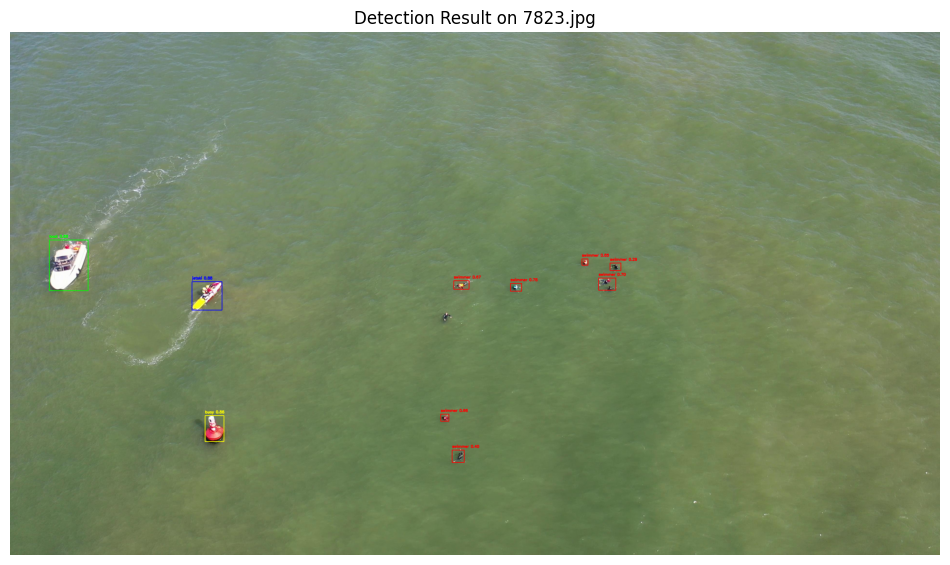

In [27]:
# Load model đã train
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Thư mục ảnh test
test_image_dir = "/kaggle/input/seadronessee-with-labels/SeaDronesSee/compressed/images/test"

# Màu sắc cho từng class (đã bỏ qua class ignored)
colors = {
    0: (255, 0, 0),       # swimmer - đỏ
    1: (0, 255, 0),       # boat - xanh lá
    2: (0, 0, 255),       # jetski - xanh dương
    3: (255, 165, 0),     # life_saving_appliances - cam
    4: (255, 255, 0)      # buoy - vàng
}

# Lấy 1 ảnh ngẫu nhiên
test_images = [f for f in os.listdir(test_image_dir) if f.endswith((".jpg", ".png"))]
img_name = random.choice(test_images)
img_path = os.path.join(test_image_dir, img_name)

results = model.predict(img_path, imgsz=640)

# Load ảnh gốc
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Vẽ bounding box
for result in results:
    boxes = result.boxes
    for box in boxes:
        cls = int(box.cls[0])
        conf = box.conf[0]
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        color = colors.get(cls, (255, 255, 255))  # màu trắng nếu không xác định
        label = f"{model.names[cls]} {conf:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Hiển thị ảnh
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.title(f"Detection Result on {img_name}")
plt.axis('off')
plt.show()